#OBTENER FUENTES

In [1]:
!git clone https://github.com/computer-vision-pucp/crowd-counting

Cloning into 'crowd-counting'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 69 (delta 12), reused 45 (delta 8), pack-reused 0
Unpacking objects: 100% (69/69), done.


In [2]:
!cp '/content/drive/MyDrive/CV-Conteo Multitudes/CSRNet/modelo_entrenado.tar' '/content/'
!cp '/content/drive/MyDrive/CV-Conteo Multitudes/CSRNet/part_A_train.json' '/content/'
!cp '/content/drive/MyDrive/CV-Conteo Multitudes/CSRNet/part_A_val.json' '/content/'
!cp '/content/crowd-counting/csrnet/dataset.py' '/content/'
!cp '/content/crowd-counting/csrnet/image.py' '/content/'
!cp '/content/crowd-counting/csrnet/model.py' '/content/'
!cp '/content/crowd-counting/csrnet/train.py' '/content/'
!cp '/content/crowd-counting/csrnet/utils.py' '/content/'

#IMPORTAR MODULOS

In [3]:
# importing libraries
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import scipy
from scipy import spatial
import json
from matplotlib import cm as CM
from image import *
from model import CSRNet
import torch
from tqdm import tqdm
import math
import requests
from io import BytesIO
%matplotlib inline


#GENERAR GROUND TRUTH

In [4]:
def gaussian_filter_density(gt):
    print (gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    leafsize = 2048
    # build kdtree
    # BUSQUED RÁPIDA DEL VECINO MÁS CERCANO
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    print ('generate density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print ('done.')
    return density

In [ ]:
img_paths = []

for img_path in glob.glob("/content/drive/MyDrive/Colab Notebooks/part_A_mini/train_data/images/*.jpg"):
    img_paths.append(img_path)
    None

for img_path in glob.glob("/content/drive/MyDrive/Colab Notebooks/part_A_mini/test_data/images/*.jpg"):
    img_paths.append(img_path)
    None

for img_path in glob.glob("/content/drive/MyDrive/Colab Notebooks/part_B_mini/train_data/images/*.jpg"):
    img_paths.append(img_path)
    None

for img_path in glob.glob("/content/drive/MyDrive/Colab Notebooks/part_B_mini/test_data/images/*.jpg"):
    img_paths.append(img_path)
    None

In [ ]:
#SOLO ES REQUERIDA SI SE QUIERE GENERAR LAS DENSIDADES DE CADA IMAGEN
for img_path in img_paths:
    print (img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground-truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter_density(k)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground-truth'), 'w') as hf:
            hf['density'] = k

/content/drive/MyDrive/Colab Notebooks/part_A_mini/test_data/images/IMG_18.jpg
(681, 1024)
generate density...
done.
/content/drive/MyDrive/Colab Notebooks/part_A_mini/test_data/images/IMG_17.jpg
(508, 997)
generate density...
done.
/content/drive/MyDrive/Colab Notebooks/part_A_mini/test_data/images/IMG_24.jpg
(633, 1024)
generate density...
done.
/content/drive/MyDrive/Colab Notebooks/part_A_mini/test_data/images/IMG_20.jpg
(683, 1024)
generate density...
done.
/content/drive/MyDrive/Colab Notebooks/part_A_mini/test_data/images/IMG_25.jpg
(681, 1024)
generate density...
done.
/content/drive/MyDrive/Colab Notebooks/part_A_mini/test_data/images/IMG_23.jpg
(942, 1024)
generate density...
done.
/content/drive/MyDrive/Colab Notebooks/part_A_mini/test_data/images/IMG_22.jpg
(540, 720)
generate density...
done.
/content/drive/MyDrive/Colab Notebooks/part_A_mini/test_data/images/IMG_21.jpg
(683, 1024)
generate density...
done.
/content/drive/MyDrive/Colab Notebooks/part_A_mini/test_data/image

#ENTRENAR MODELO

In [ ]:
#!python train.py part_A_train.json part_A_val.json 0 0
#SE USO EL MODELO PREENTRENADO

#VALIDAR

In [5]:
from torchvision import datasets, transforms
transform=transforms.Compose([
                       transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
                   ])

In [10]:
img_paths_train = []

for img_path in glob.glob("/content/drive/MyDrive/Colab Notebooks/part_A_mini/train_data/images/*.jpg"):
    img_paths_train.append(img_path)

In [7]:
model = CSRNet()
model = model.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [8]:
checkpoint = torch.load('modelo_entrenado.tar')
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [ ]:
mae = 0
mse = 0
for i in tqdm(range(len(img_paths_train))):
    img = transform(Image.open(img_paths_train[i]).convert('RGB')).cuda()
    gt_file = h5py.File(img_paths_train[i].replace('.jpg','.h5').replace('images','ground-truth'),'r')
    groundtruth = np.asarray(gt_file['density'])
    output = model(img.unsqueeze(0))
    mae += abs(output.detach().cpu().sum().numpy()-np.sum(groundtruth))
    mse += (output.detach().cpu().sum().numpy()-np.sum(groundtruth))**2
print ('\nmae=', mae/len(img_paths_train))
print ('mse=', math.sqrt(mse/len(img_paths_train)) )

100%|██████████| 5/5 [00:16<00:00,  3.35s/it]


mae= 42.55858459472656
mse= 53.78186995004176


##COMPROBAR CON IMAGEN ALEATORIA

Original Image


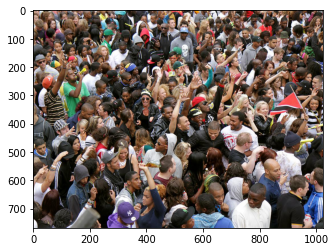

Original Count :  229


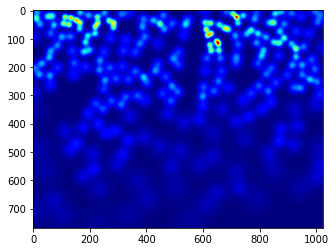

Predicted Count :  224


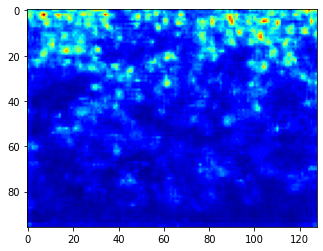

In [11]:
#path = '/content/drive/MyDrive/Colab Notebooks/part_A_mini/train_data/images/IMG_34.jpg';
path = random.choice(img_paths_train)

from matplotlib import cm as c
img = transform(Image.open(path).convert('RGB')).cuda()

output = model(img.unsqueeze(0))


print("Original Image")
plt.imshow(plt.imread(path))
plt.show()

temp = h5py.File(path.replace('.jpg','.h5').replace('images','ground-truth'), 'r')
temp_1 = np.asarray(temp['density'])
plt.imshow(temp_1,cmap = c.jet)
print("Original Count : ",int(np.sum(temp_1)) + 1)
plt.show()

print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp,cmap = c.jet)
plt.show()



##PRUEBA CON IMAGEN TRAIDA DE INTERNET

Image


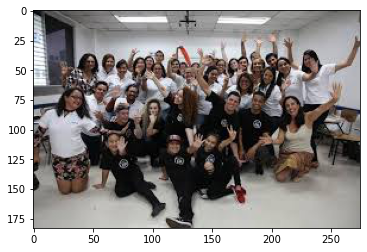

Predicted Count :  60


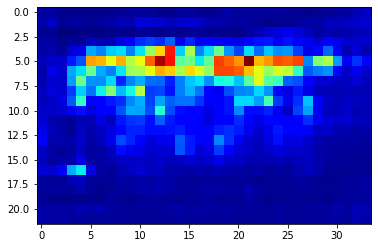

In [13]:
im = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSs6IORbIQAdS9UkZcpgmWTV0nKBWRq2XKiYQ&usqp=CAU"
im = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRwOZVQ6ZDimAUvo_GuVQYs3d3EZLTsGIUrbw&usqp=CAU"
#im = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSKvta7YGe0iWlluXyUwRJVAUNP_0oy7yDtMA&usqp=CAU"
response = requests.get(im)

print("Image")
plt.imshow(Image.open(BytesIO(response.content)))
plt.show()

from matplotlib import cm as c
img = transform(Image.open(BytesIO(response.content)).convert('RGB')).cuda()

output = model(img.unsqueeze(0))

print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp,cmap = c.jet)
plt.show()
